image.png

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
### Tecnológico de Monterrey
###  	Dr. David Antonio Torres

#### **Proyecto Final - Behavioral Cloning**
##### **Simulador Udacity**
____


**Nombres y matrículas de los integrantes del equipo:**

*   Julio Cesar Lynn Jimenez A01793660
*   Francisco Javier Parga García A01794380
*   Carlos Roberto Torres Ferguson A01215432
*   Fernando Sebastian Sanchez Cardona A01687530

____

# Librerias

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [70]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

___
Mediante la creación de imágenes con el simulador de Udacity, se generó el set de datos para entrenamiento del modelo. 
Se manejó de forma asistida durante aproximadamente 4 vueltas para generar suficientes imágenes.
___

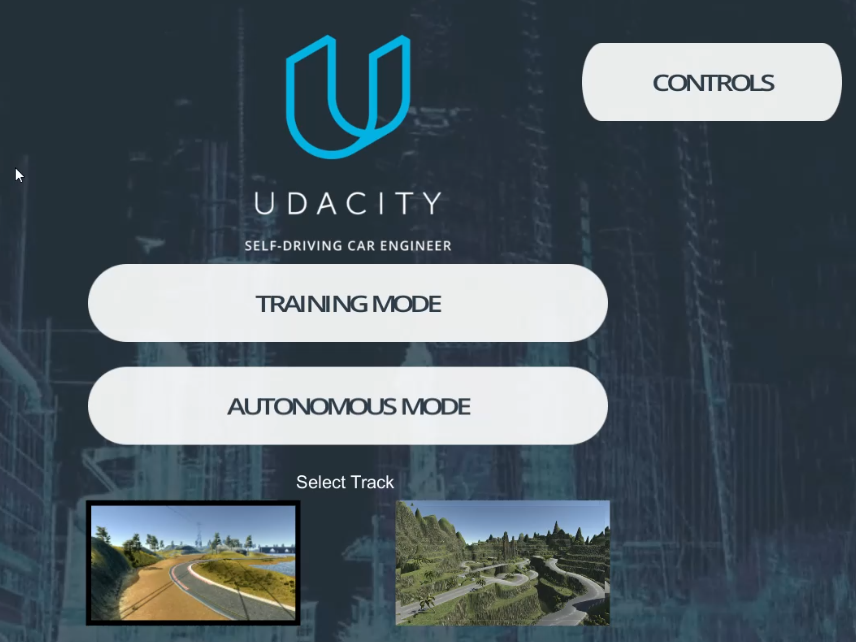

## Cargar imágenes de entrenamiento y registros de manejo

In [71]:
datadir = 'c:' + os.sep + 'udacity self-drive sim' + os.sep + 'beta_simulator_windows' + os.sep + 'output' + os.sep + 'Track_CNN' + os.sep 

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
# pd.set_option('display.max_colwidth', -1)

data.head()

center   
0  C:\udacity self-drive sim\beta_simulator_windo...  \
1  C:\udacity self-drive sim\beta_simulator_windo...   
2  C:\udacity self-drive sim\beta_simulator_windo...   
3  C:\udacity self-drive sim\beta_simulator_windo...   
4  C:\udacity self-drive sim\beta_simulator_windo...   

                                                left   
0  C:\udacity self-drive sim\beta_simulator_windo...  \
1  C:\udacity self-drive sim\beta_simulator_windo...   
2  C:\udacity self-drive sim\beta_simulator_windo...   
3  C:\udacity self-drive sim\beta_simulator_windo...   
4  C:\udacity self-drive sim\beta_simulator_windo...   

                                               right  steering  throttle   
0  C:\udacity self-drive sim\beta_simulator_windo...       0.0       0.0  \
1  C:\udacity self-drive sim\beta_simulator_windo...       0.0       0.0   
2  C:\udacity self-drive sim\beta_simulator_windo...       0.0       0.0   
3  C:\udacity self-drive sim\beta_simulator_windo...       0.0       0.0   
4  C:\udacity self-drive sim\beta_simulator_windo...       0.0       0.0   

   reverse     speed  
0      0.0  0.000097  
1      0.0  0.000118  
2      0.0  0.000205  
3      0.0  0.000260  
4      0.0  0.000041

In [72]:
# Limplieza del data frame
def path_leaf(path):
    # : This module provides os.path functionality on Windows platforms.
    # : ntpath.split() gives the file name and folder path
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left   
0  center_2023_06_21_19_11_54_824.jpg  left_2023_06_21_19_11_54_824.jpg  \
1  center_2023_06_21_19_11_54_897.jpg  left_2023_06_21_19_11_54_897.jpg   
2  center_2023_06_21_19_11_54_968.jpg  left_2023_06_21_19_11_54_968.jpg   
3  center_2023_06_21_19_11_55_041.jpg  left_2023_06_21_19_11_55_041.jpg   
4  center_2023_06_21_19_11_55_114.jpg  left_2023_06_21_19_11_55_114.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2023_06_21_19_11_54_824.jpg       0.0       0.0      0.0  0.000097  
1  right_2023_06_21_19_11_54_897.jpg       0.0       0.0      0.0  0.000118  
2  right_2023_06_21_19_11_54_968.jpg       0.0       0.0      0.0  0.000205  
3  right_2023_06_21_19_11_55_041.jpg       0.0       0.0      0.0  0.000260  
4  right_2023_06_21_19_11_55_114.jpg       0.0       0.0      0.0  0.000041

In [73]:
# Distribución del steering durante el manejo asistido
num_bins = 25

samples_per_bin = 400

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

___
Dado que hay un desvalanceo fuerte de datos sin ángulo de vuelta, se eliminaron imágenes con `steering  = 0` para balancear el dato de etrenamiento.
___

In [74]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 37286
removed: 27714
remaining: 9572


# Carga de imagenes a utilizar

___
Inicialmente se intentó usar únicamente las imágenes de la cámara central, pero no se logró un modelo que resolviera de forma autónoma, por lo que se decidió usar las 3 cámaras.
___

In [75]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2023_06_21_19_11_55_613.jpg
left          left_2023_06_21_19_11_55_613.jpg
right        right_2023_06_21_19_11_55_613.jpg
steering                                 -0.15
throttle                                   1.0
reverse                                    0.0
speed                                 3.635508
Name: 11, dtype: object


# Se divide el conjunto de datos en entrenamiento y validación

___
Se dividió el dato en entrenamiento y validación en una proporción del `Train = 80%`, `Val = 20%`
___

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 22972
Valid Samples: 5744


Text(0.5, 1.0, 'Validation set')

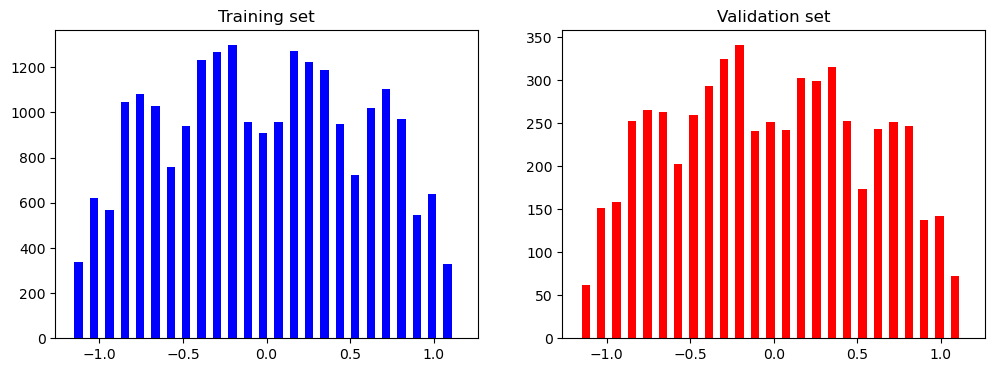

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Aumente de datos

___
Para incrementar las variaciones en las imágenes se aplicaron distintas transformaciones para ayudar al modelo a generalizar mejor:
 - Zoom
 - Panning
 - Brightness
 - Flip
___

## Zoom

Text(0.5, 1.0, 'Zoomed Image')

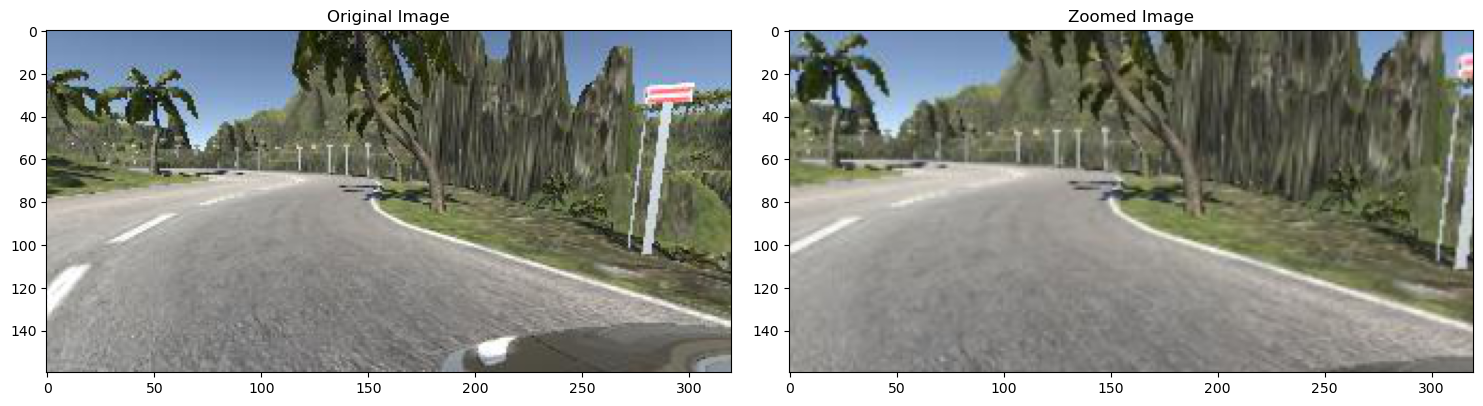

In [78]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

## Panning

Text(0.5, 1.0, 'Panned Image')

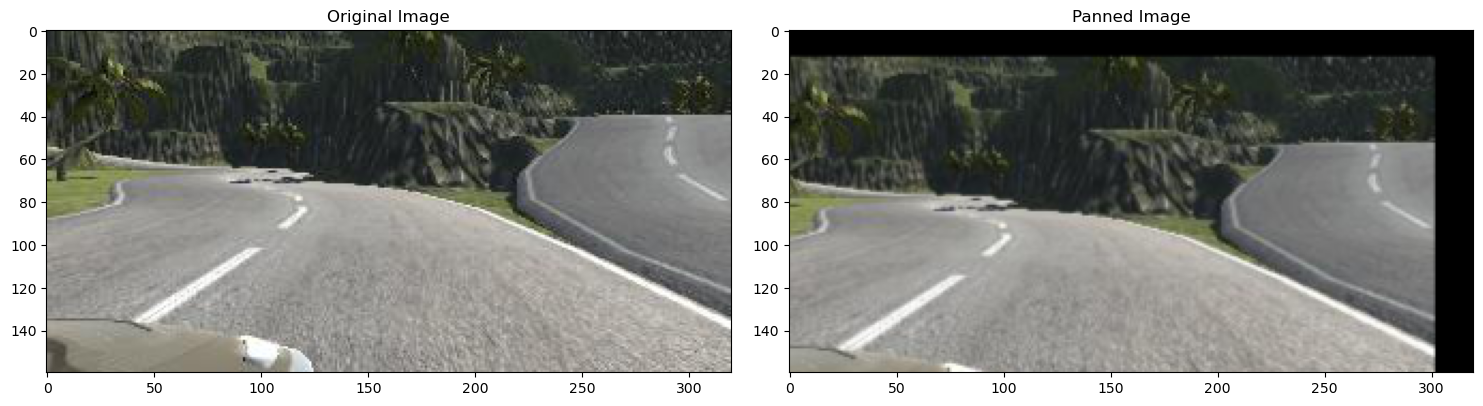

In [79]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

## Brightness

Text(0.5, 1.0, 'Brightness altered image ')

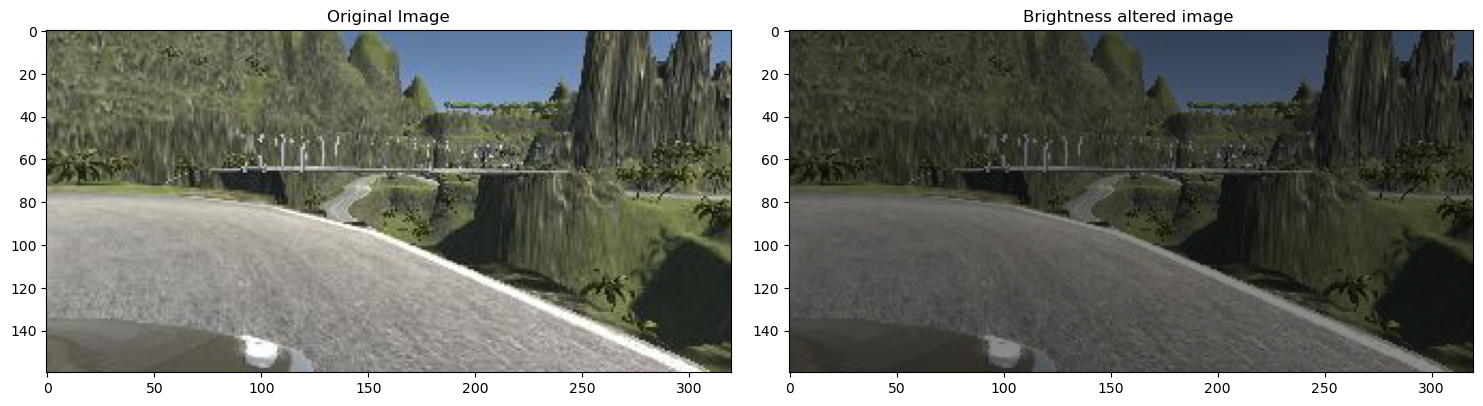

In [80]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

## Flip

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-1.0000001')

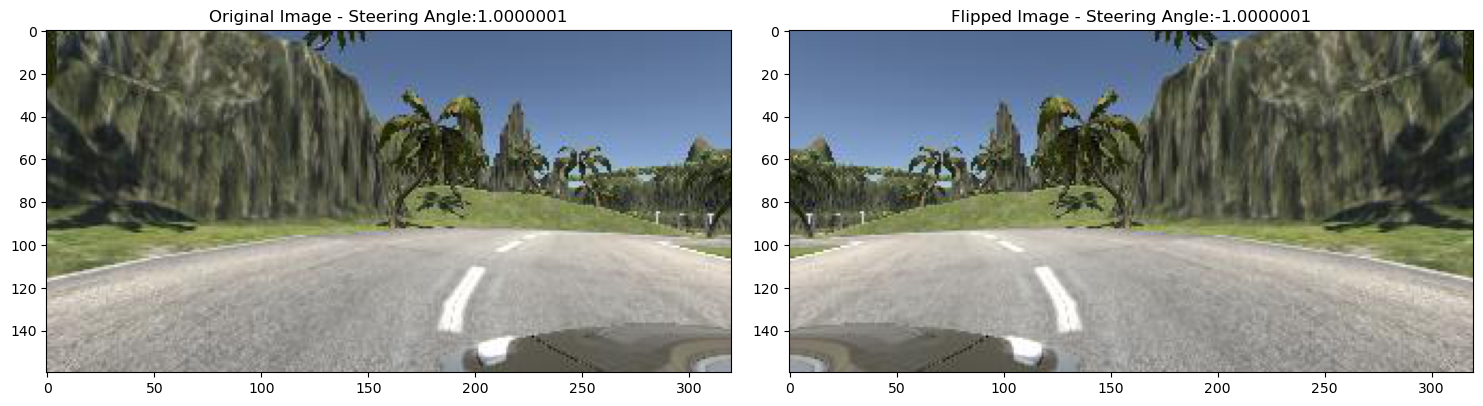

In [81]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

## Data aumentation

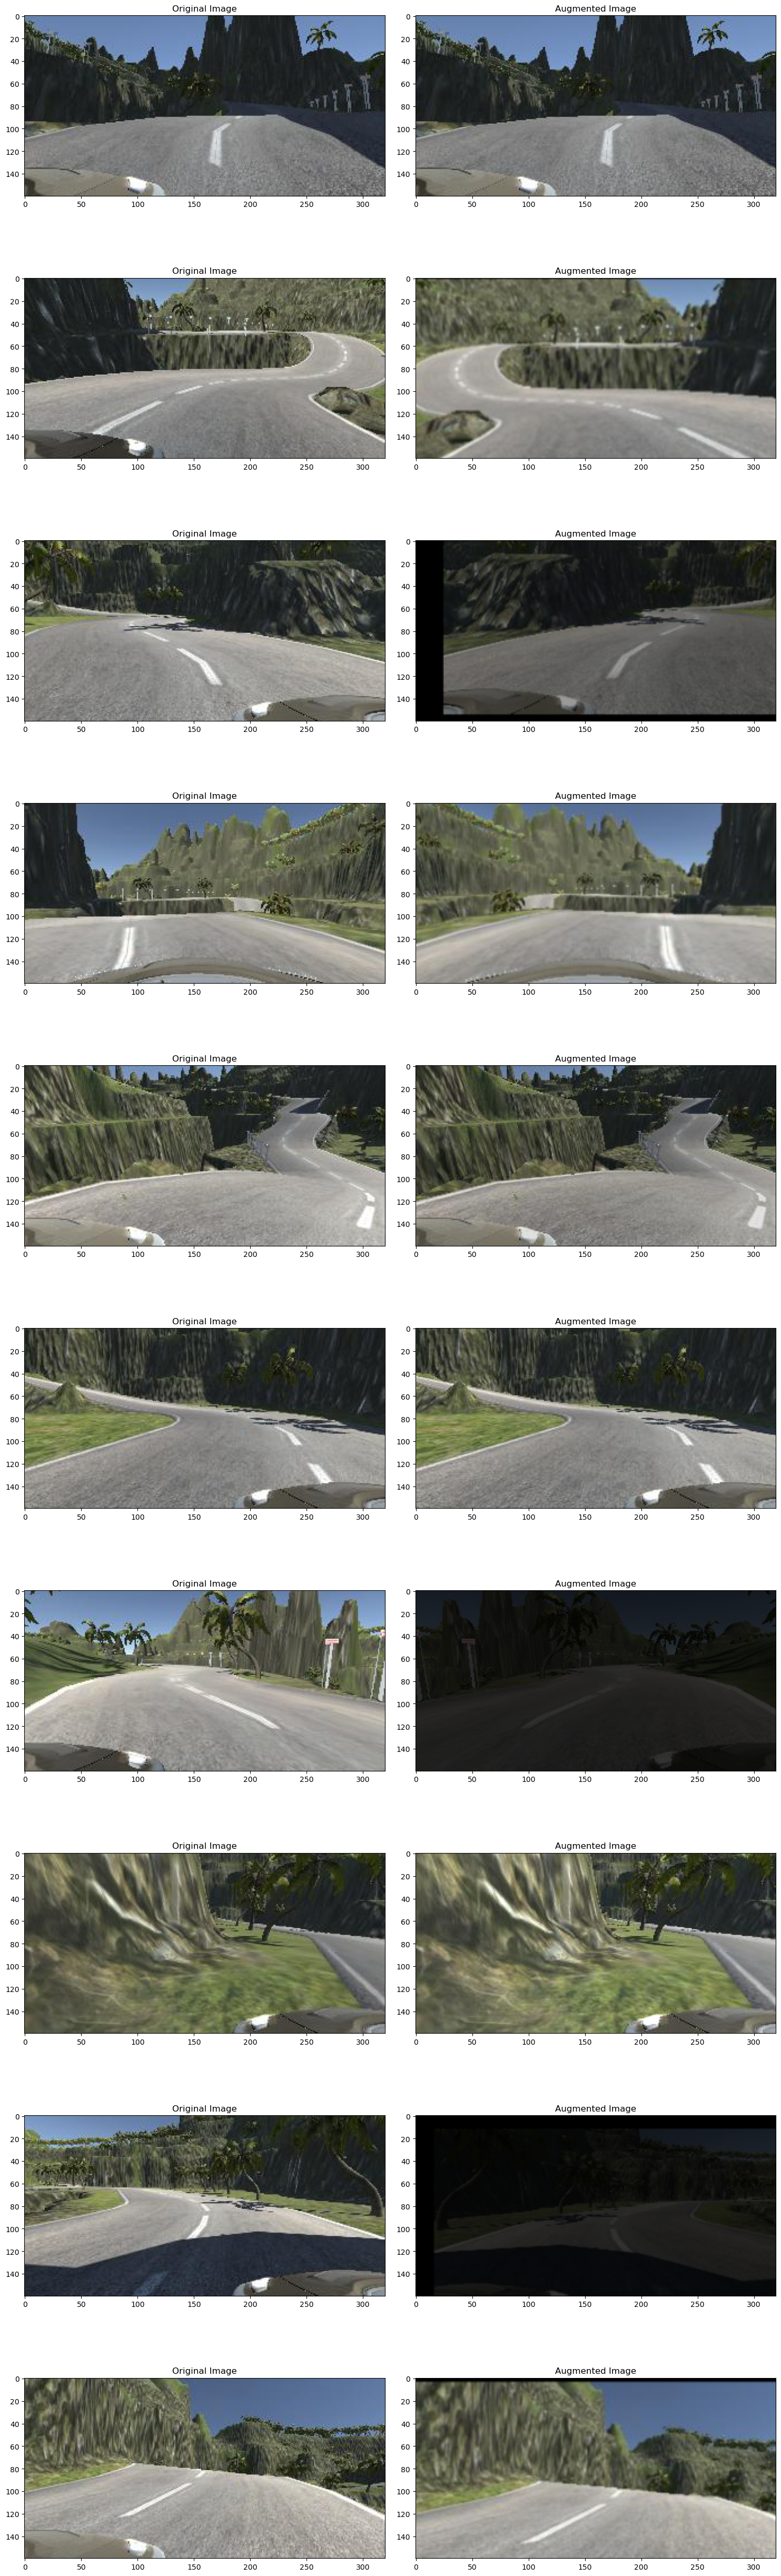

In [82]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle


ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

# Pre-processing

___
Para homologar un poco las imágens y evitar bordes muy fuertes en las imágens se aplicó un `GaussianBlur` y se homologó el tamaño de las imágenes a `200x66` pixeles para que sean compatibles en el modo autónomo con el simulador y modelo
___

Text(0.5, 1.0, 'Preprocessed Image')

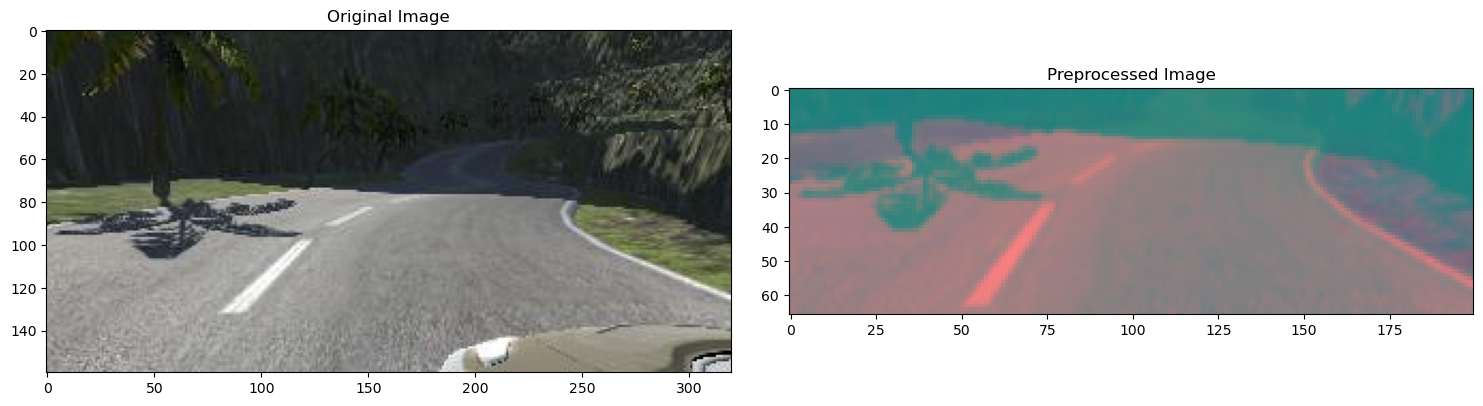

In [83]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

# Entrenamiento del modelo

___
Dada la cantidad de datos a usar para el entrenamiento, es necesario dividir el dato en batches, por lo que se creó un método que suministre los batches en cada época.
___

In [84]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):

            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
              # orig_im = mpimg.imread(image_paths[random_index])
              # orig_steering = steering_ang[random_index]
              # orig_im = img_preprocess(orig_im)
              # batch_img.append(orig_im)
              # batch_steering.append(orig_steering)
              im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
              im = mpimg.imread(image_paths[random_index])
              steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [85]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

Text(0.5, 1.0, 'Validation Image')

## Definición del Modelo

___
Para el modelo, se utilizó la misma arquitectura que la sugerida por NVIDIA.

Se adicionaron capas `Dropout` a las capas `Densas` para regularizar el modelo y evitar sobre-entrenamiento
___

In [86]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
model.add(tf.keras.layers.Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(tf.keras.layers.Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='elu'))

model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='elu'))
model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(50, activation = 'elu'))
model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Dense(10, activation = 'elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

optimizer = Adam(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer)

c:\tools\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [87]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_12 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

## Entrenamiento inicial

___
Para lograr un modelo robusto, se utilizó un entrenamiento de `epoch=100`, con `steps_per_epoch=500` y `batch=150`.
Estos parámetros nos permitirán entrenar el modelo con 75,000 imágenes por época y gracias a la aumentación de datos habrá diferencia en todas ellas, por lo que nos ayudará a generalizar mejor.
___

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 150, 1),
                              steps_per_epoch=500,
                              epochs=100,
                              validation_data=batch_generator(X_valid, y_valid, 150, 0),
                              validation_steps=300,
                              verbose=1,
                              shuffle = 1)

C:\Users\julio\AppData\Local\Temp\ipykernel_17924\553031827.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 150, 1),


Epoch 1/100
500/500 [==============================] - 460s 901ms/step - loss: 0.3044 - val_loss: 0.1807
Epoch 2/100
500/500 [==============================] - 331s 663ms/step - loss: 0.2473 - val_loss: 0.1850
Epoch 3/100
500/500 [==============================] - 332s 665ms/step - loss: 0.2355 - val_loss: 0.1805
Epoch 4/100
500/500 [==============================] - 361s 724ms/step - loss: 0.2296 - val_loss: 0.1818
Epoch 5/100
500/500 [==============================] - 342s 685ms/step - loss: 0.2266 - val_loss: 0.1819
Epoch 6/100
500/500 [==============================] - 347s 695ms/step - loss: 0.2206 - val_loss: 0.1786
Epoch 7/100
500/500 [==============================] - 361s 723ms/step - loss: 0.2213 - val_loss: 0.1769
Epoch 8/100
500/500 [==============================] - 326s 653ms/step - loss: 0.2176 - val_loss: 0.1877
Epoch 9/100
500/500 [==============================] - 363s 727ms/step - loss: 0.2151 - val_loss: 0.1700
Epoch 10/100
500/500 [==============================] -

Text(0.5, 0, 'Epoch')

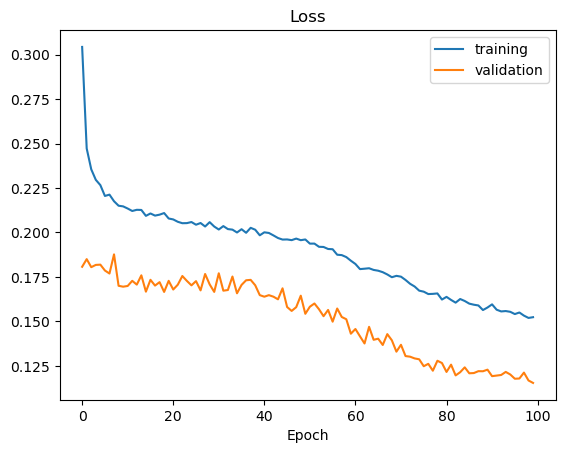

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('pista2_local_model.h5')

### Continuación de entrenaiento

___
La evaluación del modo autónomo mostré que el modelo casi lograba su cometido, por lo que se continuó con el entrenamiento con una variación de imágenes para ajustarlo un poco más y generalizarlo mejor.
___

In [88]:
model.load_weights('pista2_local_model.h5')

In [89]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              callbacks=[callback],
                              verbose=1,
                              shuffle = 1)

C:\Users\julio\AppData\Local\Temp\ipykernel_18892\1702182736.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 367s 1s/step - loss: 0.1530 - val_loss: 0.1093
Epoch 2/10
300/300 [==============================] - 367s 1s/step - loss: 0.1501 - val_loss: 0.1104
Epoch 3/10
300/300 [==============================] - 368s 1s/step - loss: 0.1489 - val_loss: 0.1124
Epoch 4/10
300/300 [==============================] - 362s 1s/step - loss: 0.1508 - val_loss: 0.1086
Epoch 5/10
300/300 [==============================] - 320s 1s/step - loss: 0.1501 - val_loss: 0.1083
Epoch 6/10
300/300 [==============================] - 290s 969ms/step - loss: 0.1492 - val_loss: 0.1117
Epoch 7/10
300/300 [==============================] - 369s 1s/step - loss: 0.1492 - val_loss: 0.1104
Epoch 8/10
300/300 [==============================] - 370s 1s/step - loss: 0.1510 - val_loss: 0.1087
Epoch 9/10
300/300 [==============================] - 370s 1s/step - loss: 0.1463 - val_loss: 0.1097
Epoch 10/10
300/300 [==============================] - 369s 1s/step - loss: 0.1486 - val

Text(0.5, 0, 'Epoch')

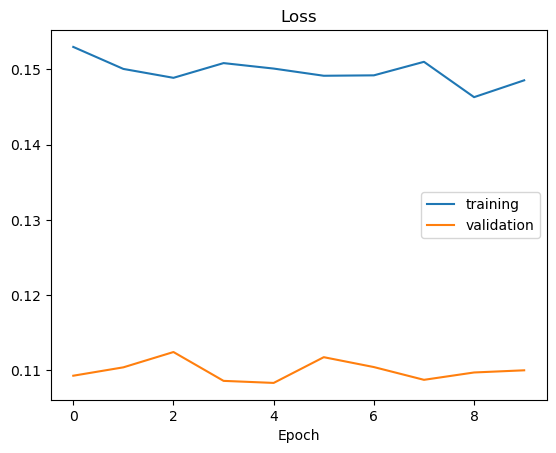

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

___
Durante el entrenamiento del modelo, se observa que se logra un ajuste con pocas épocas.
Con los `steps = 300` y 100 imágenes por batch (`batch_size=100`), en cada época el modelo se entrena con **30,000** imágenes, lo que ayuda a reducir el loss y a generalizar el modelo.

Este modelo será utilizado en el modeo autónomo para la evaliación con el simulador.
___

In [91]:
model.save('pista2_local_model.h5')